In [5]:
from PIL import Image, ImageDraw
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoProcessor, Owlv2ForObjectDetection
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

In [6]:
processor = AutoProcessor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

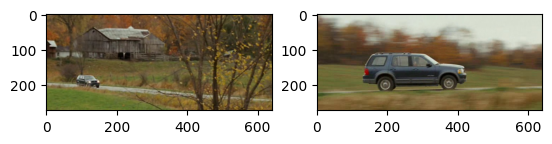

In [61]:
# query_image = Image.open(r"/projects/academic/rohini/m44/git-prjs/3DVision/Mach/data/230_white.jpg")
# query_image = query_image.convert('RGB')
query_image = Image.open(r"/projects/academic/rohini/m44/git-prjs/3DVision/Mach/data/00000230.jpg")
# query_image = Image.open(r"/projects/academic/rohini/m44/git-prjs/3DVision/Mach/classification/data/train/car/8_495.png")
query_image = query_image.convert('RGB')
image_target = Image.open(r"/projects/academic/rohini/m44/git-prjs/3DVision/Mach/data/00000120.jpg")

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_target)
ax[1].imshow(query_image)

In [ ]:
def make_square(image, desired_size=640):
    h, w, _ = image.shape
    padding_y = max(0, (desired_size - h) // 2)

    # Create a new square canvas filled with zeros (black)
    square_image = np.zeros((desired_size, desired_size, 3), dtype=np.uint8)

    # Place the original image in the center
    square_image[padding_y:padding_y + h, :, :] = image

    return square_image

# make image square
image_target = np.array(image_target)
image_target = make_square(image_target)
image_target = Image.fromarray(image_target)
image_target


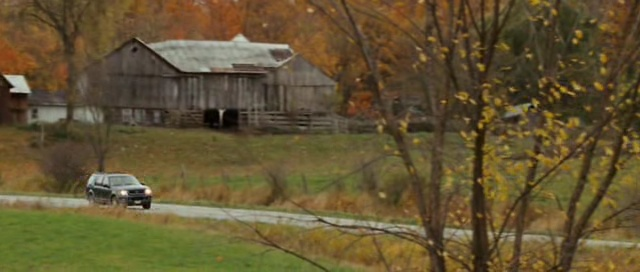

In [62]:
inputs = processor(images=image_target, query_images=query_image, return_tensors="pt")
from copy import deepcopy
test_img = deepcopy(image_target)
test_img

In [63]:
with torch.no_grad():
    outputs = model.image_guided_detection(**inputs)

def get_preprocessed_image(pixel_values):
    pixel_values = pixel_values.squeeze().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

In [64]:
unnormalized_image = get_preprocessed_image(inputs.pixel_values)
target_sizes = torch.Tensor([unnormalized_image.size[::-1]])

In [65]:
results = processor.post_process_image_guided_detection(
    outputs=outputs, threshold=0.9, nms_threshold=0.1, target_sizes=target_sizes
)

Detected similar object with confidence 0.97 at location [5.69, 1.37, 33.6, 15.47]
Detected similar object with confidence 0.961 at location [174.41, -0.11, 228.48, 41.63]
Detected similar object with confidence 0.897 at location [242.31, -0.59, 291.57, 48.58]
Detected similar object with confidence 0.932 at location [523.18, -12.43, 1391.74, 230.62]
Detected similar object with confidence 0.952 at location [18.82, 3.48, 99.68, 55.99]
Detected similar object with confidence 0.986 at location [2.36, -1.5, 353.96, 119.68]
Detected similar object with confidence 0.945 at location [309.63, -0.06, 370.22, 60.78]
Detected similar object with confidence 0.978 at location [734.29, 0.91, 891.39, 112.43]
Detected similar object with confidence 0.955 at location [871.2, -1.72, 955.63, 98.52]
Detected similar object with confidence 0.965 at location [-0.71, 46.75, 58.63, 114.64]
Detected similar object with confidence 0.894 at location [336.68, 50.92, 443.08, 99.1]
Detected similar object with con

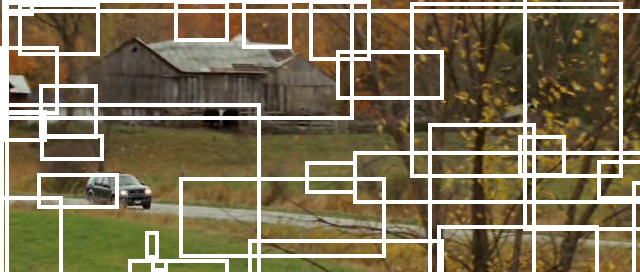

In [66]:
draw = ImageDraw.Draw(image_target)

i = 0  # Retrieve predictions for the first image
boxes, scores = results[i]["boxes"], results[i]["scores"]
for box, score in zip(boxes, scores):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected similar object with confidence {round(score.item(), 3)} at location {box}")
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="white", width=4)

image_target